In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import umap


# UMAP


In [3]:
# Import data
test = pd.read_csv("test_data_processed.csv")
train = pd.read_csv("training_data_processed.csv")

In [5]:
# Prep dataframe
#train.drop(columns=['Δ%T per °C', 'Difference from Control'], axis=1, inplace=True)

drugname = train['Drug Name']
train.drop(columns=['Drug Name'], axis=1, inplace=True)

train

,Temperature (oC),Concentration (mM),% Transmittance,Difference from Control
0,25,0,100.000000,0.000000
1,26,0,92.825365,0.000000
2,27,0,100.461579,0.000000
3,28,0,92.469817,0.000000
4,29,0,86.496792,0.000000
...,...,...,...,...
1627,36,10,116.680962,-28.101440
1628,37,10,116.860211,-29.092791
1629,38,10,116.949939,-29.719780
1630,39,10,116.770552,-29.003132


In [6]:
# scale 
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)

In [7]:
umap = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.4, random_state=44)

train_umap = umap.fit_transform(train_scaled)

c:\Users\ASUS\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


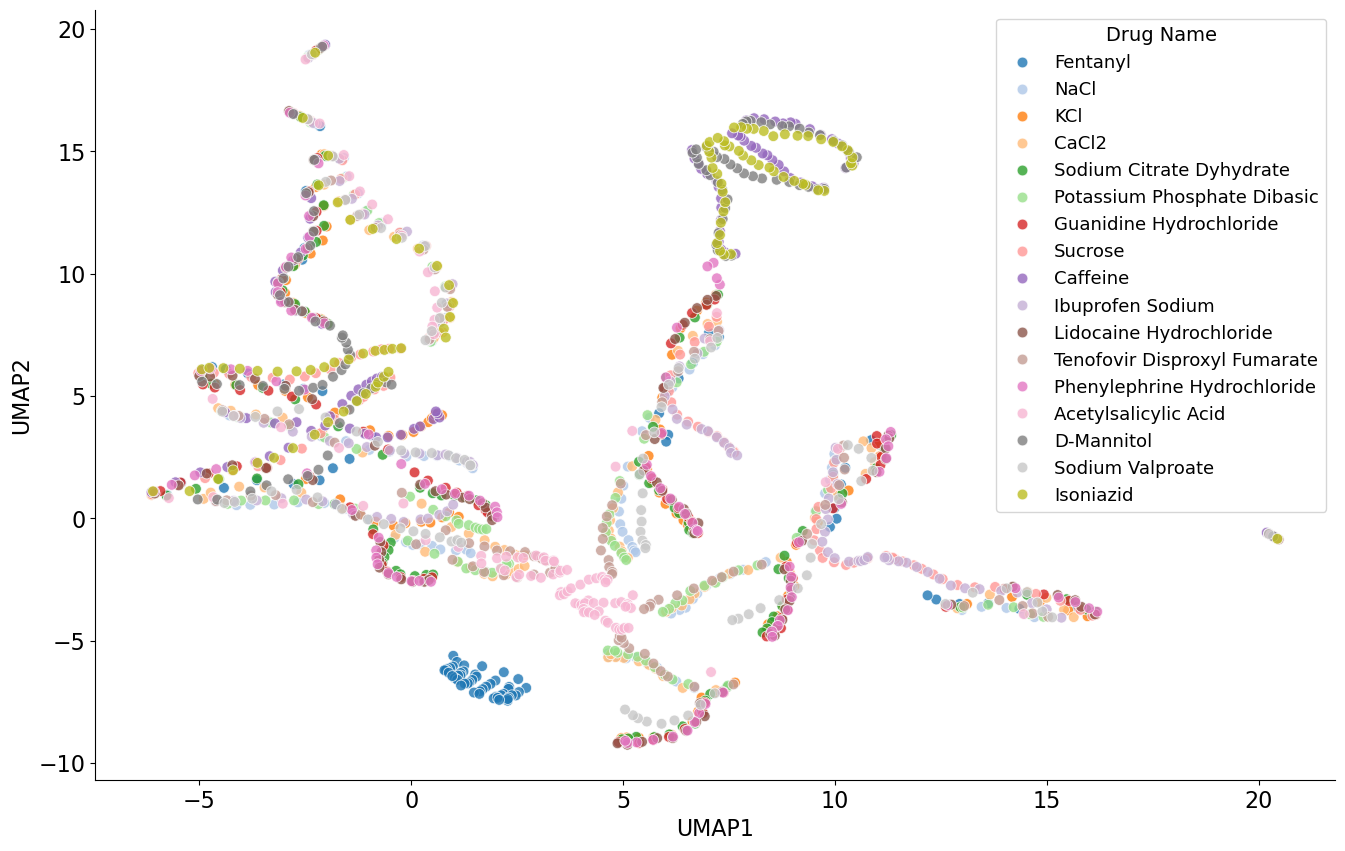

In [8]:
# Turn into dataframe for plotting
umap_df = pd.DataFrame(train_umap, columns=["UMAP1", "UMAP2"])
umap_df["Drug Name"] = drugname.values

# Plot the UMAP results with a hue based on absorbance values
plt.figure(figsize=(16, 10))

sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='Drug Name',
    palette='tab20',
    data=umap_df,
    alpha=0.8,
    s=60
)

plt.xlabel("UMAP1", size=16)
plt.ylabel("UMAP2", size=16)
plt.xticks(size=16)
plt.yticks(size=16)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(title='Drug Name', fontsize=13, title_fontsize=14)

plt.savefig("umap_alldrugs.png", dpi=300, bbox_inches='tight')


plt.show()

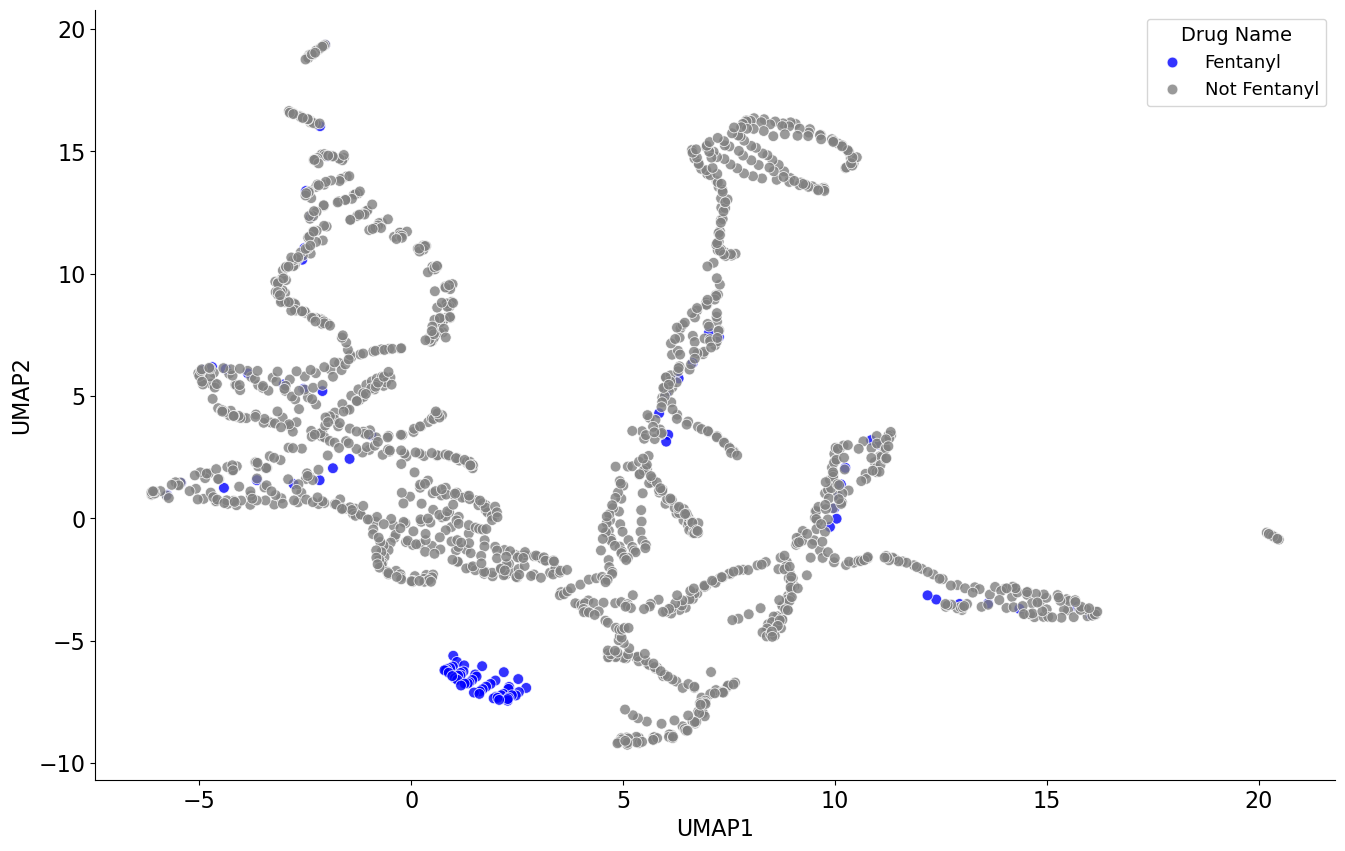

In [9]:
umap_df['Label'] = umap_df['Drug Name'].apply(lambda x: 'Fentanyl' if x == 'Fentanyl' else 'Not Fentanyl')

# Plot the UMAP results with a hue based on absorbance values
plt.figure(figsize=(16, 10))

sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='Label',
    palette={'Fentanyl': 'blue', 'Not Fentanyl': 'grey'},
    data=umap_df,
    alpha=0.8,
    s=60
)

plt.xlabel("UMAP1", size=16)
plt.ylabel("UMAP2", size=16)
plt.xticks(size=16)
plt.yticks(size=16)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(title='Drug Name', fontsize=13, title_fontsize=14)

plt.savefig("umap_fentanyl_only.png", dpi=300, bbox_inches='tight')

plt.show()

# Interactive UMAP

In [10]:
# Combine data
all_data = pd.concat([train, umap_df], axis=1)

all_data

,Temperature (oC),Concentration (mM),% Transmittance,Difference from Control,UMAP1,UMAP2,Drug Name,Label
0,25,0,100.000000,0.000000,20.297735,-0.690716,Fentanyl,Fentanyl
1,26,0,92.825365,0.000000,-2.034142,19.346638,Fentanyl,Fentanyl
2,27,0,100.461579,0.000000,-2.155066,16.025127,Fentanyl,Fentanyl
3,28,0,92.469817,0.000000,-1.982614,14.802212,Fentanyl,Fentanyl
4,29,0,86.496792,0.000000,-2.486649,13.378160,Fentanyl,Fentanyl
...,...,...,...,...,...,...,...,...
1627,36,10,116.680962,-28.101440,8.316734,15.826434,Isoniazid,Not Fentanyl
1628,37,10,116.860211,-29.092791,8.079419,15.912743,Isoniazid,Not Fentanyl
1629,38,10,116.949939,-29.719780,7.921678,15.920732,Isoniazid,Not Fentanyl
1630,39,10,116.770552,-29.003132,7.784186,15.983093,Isoniazid,Not Fentanyl


In [11]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_file, save
from matplotlib import cm
import matplotlib.pyplot as plt

# Get colour scheme
tab20 = cm.get_cmap('tab20').colors
bokeh_palette = ['#%02x%02x%02x' % tuple(int(255 * c) for c in rgb) for rgb in tab20]

output_notebook()

# Set up Bokeh figure
p = figure(
    title="UMAP Projection of Drug Responses",
    tools="pan,wheel_zoom,box_zoom,reset,save,hover",
    width=900,
    height=700,
)

# Unique drugs and colors
drug_names = all_data["Drug Name"].unique()
colors = bokeh_palette[:len(drug_names)]

# Plot drugs individually (so legend is clickable)
for i, drug in enumerate(drug_names):
    subset = all_data[all_data["Drug Name"] == drug]
    source = ColumnDataSource(subset)

    p.circle(
        x='UMAP1',
        y='UMAP2',
        source=source,
        size=5,
        alpha=0.8,
        color=colors[i],
        legend_label=drug
    )

# Hover tool
hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Drug", "@{Drug Name}"),
    ("UMAP1", "@UMAP1{0.2f}"),
    ("UMAP2", "@UMAP2{0.2f}"),
    ("Temperature (°C)", "@{Temperature (oC)}{0.2f}"),
    ("Concentration (mM)", "@{Concentration (mM)}{0.2f}"),
    ("% Difference from Control", "@{% Difference from Control}{0.2f}"),
    ("% Transmittance", "@{% Transmittance}{0.2f}")
]

p.legend.title = "Drug Name"
p.legend.label_text_font_size = "11pt"
p.legend.title_text_font_size = "12pt"
p.legend.location = "top_right"
p.legend.click_policy = "hide"

p.xaxis.major_label_text_font_size = "14pt"
p.yaxis.major_label_text_font_size = "14pt"

p.xaxis.axis_label_text_font_size = "16pt"
p.yaxis.axis_label_text_font_size = "16pt"

p.title.text_font_size = "14pt"

p.xaxis.axis_label = "UMAP1"
p.yaxis.axis_label = "UMAP2"
p.xgrid.visible = False
p.ygrid.visible = False

output_file("interactive_umap.html")
save(p)

# Show
#show(p)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_35240\2802720505.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20 = cm.get_cmap('tab20').colors


Loading BokehJS ...

'c:\\Users\\ASUS\\OneDrive\\CDT\\Side projects\\niamh_pca\\UMAP\\interactive_umap.html'